### Важность признаков: запуск, визуализация и списки

Этот ноутбук рассчитывает важность признаков для моделей текущего эксперимента (указан в `04_configs/models.yml`), сохраняет результаты и строит графики.

- **Что делает:**
  - Автоматически находит файл признаков по `06_reports/experiments.csv`
  - Считает нативную важность, permutation importance (`scoring` из конфига) и SHAP (если доступен)
  - Сохраняет `raw_importances.csv`, `summary_importances.csv`, `fi_meta.json` и PNG-графики в `.../feature_importance/`
- **Что смотреть далее:**
  - В первой кодовой ячейке запускается расчёт и печатаются пути к сохранённым CSV
  - Затем строятся столбчатые диаграммы по `avg_total`, `avg_native`, `avg_perm`
  - Ниже выводятся отсортированные списки признаков с очками


In [1]:
from pathlib import Path
from importlib import reload
import json

# Добавим корень проекта в sys.path
import sys

def find_project_root(start_dir: Path) -> Path:
    candidate = start_dir
    for _ in range(10):
        if (candidate / "03_src").exists() and (candidate / "04_configs").exists():
            return candidate
        candidate = candidate.parent
    return start_dir

try:
    current_path = Path(__file__).resolve()
    start_dir = current_path.parent
except NameError:
    start_dir = Path.cwd().resolve()

project_root = find_project_root(start_dir)
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

# Прямой импорт модуля по абсолютному пути
import importlib.util
fi_path = project_root / "03_src/models/feature_importance.py"
spec = importlib.util.spec_from_file_location("feature_importance", str(fi_path))
fi = importlib.util.module_from_spec(spec)
sys.modules[spec.name] = fi
spec.loader.exec_module(fi)  # type: ignore

# Конфигурация запуска (пути относительно корня проекта trading_predictor)
models_cfg_path = "04_configs/models.yml"
reports_dir = "06_reports"

# Автоопределение файла признаков по experiments.csv (укажите None или 'auto')
features_path = None  # или 'auto'; можно задать конкретный путь к parquet

cfg = fi.ImportanceConfig(scoring="f1_macro", n_repeats=10, random_state=42, shap_max_samples=3000)

res = fi.compute_feature_importance_for_experiment(
    experiment_id=None,  # взять из models.yml
    models_subset=None,  # взять все enabled в models.yml
    features_path=features_path,
    reports_dir=reports_dir,
    models_cfg_path=models_cfg_path,
    cfg=cfg,
)

print(json.dumps(res, indent=2, ensure_ascii=False))



{
  "raw_importances": "C:\\Users\\Shchurov\\Хранилище\\Документы\\05_Программирование\\02_projects\\personal\\trading_predictor\\06_reports\\exp_0014_20250924_012531\\feature_importance\\raw_importances.csv",
  "summary_importances": "C:\\Users\\Shchurov\\Хранилище\\Документы\\05_Программирование\\02_projects\\personal\\trading_predictor\\06_reports\\exp_0014_20250924_012531\\feature_importance\\summary_importances.csv"
}


### Визуализация важности признаков

Ниже строятся горизонтальные столбчатые диаграммы важности признаков:
- **avg_total**: средняя важность по всем доступным методам (native/permutation)
- **avg_native** и **avg_perm**: компоненты сводной метрики

Графики также сохраняются в папку `feature_importance` текущего эксперимента рядом с файлами `raw_importances.csv` и `summary_importances.csv`. Убедитесь, что вы выполнили первую ячейку (расчёт важностей), чтобы переменная `res` с путями была доступна.


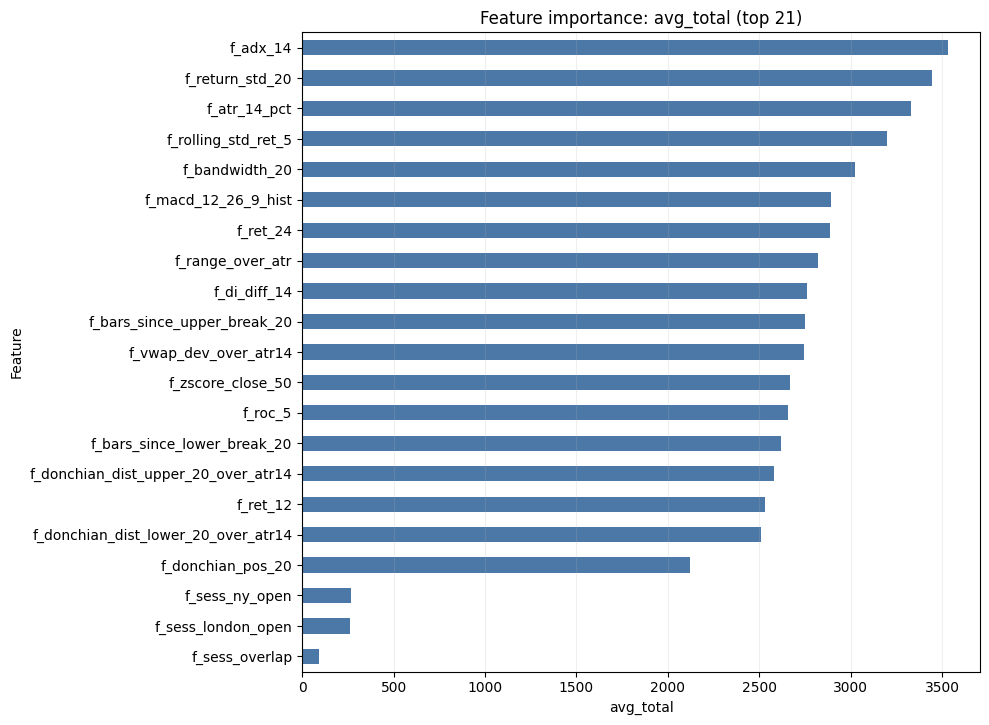

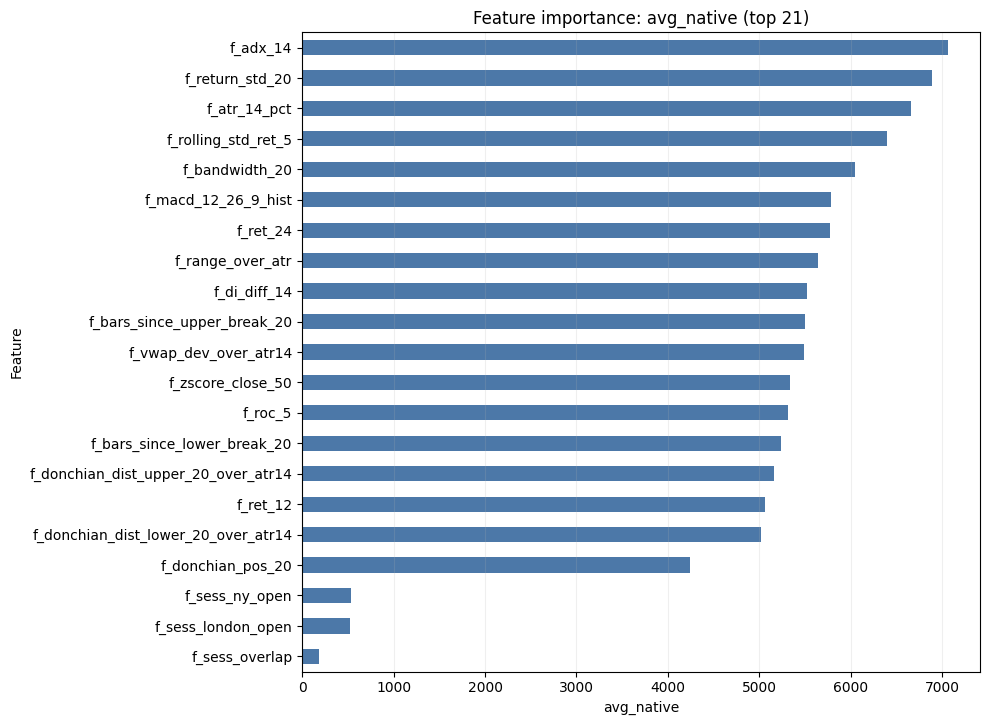

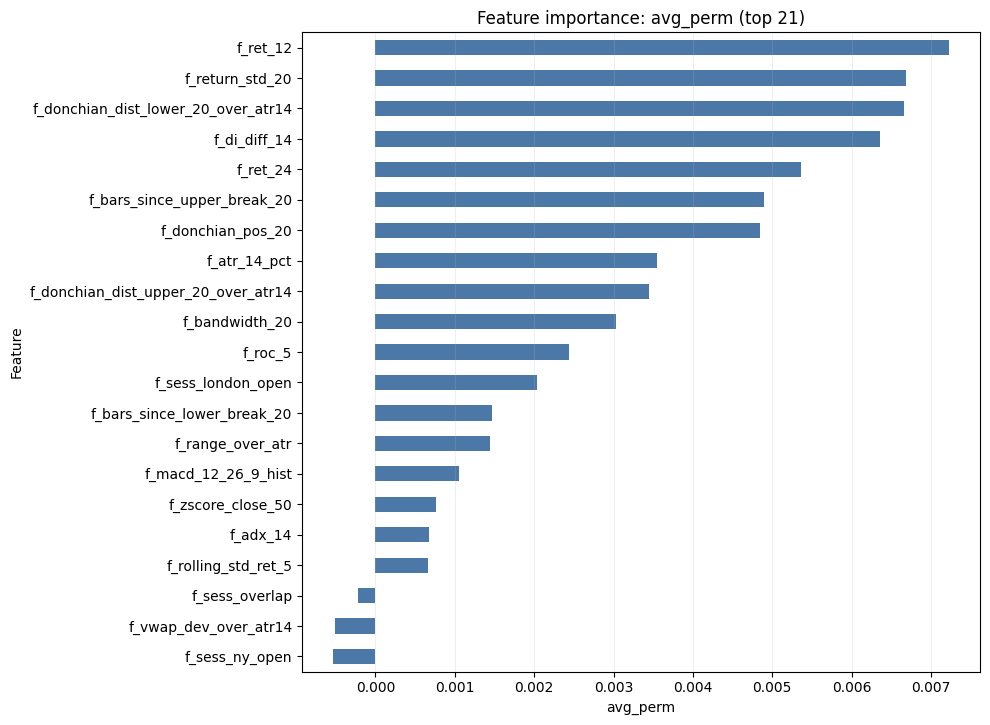

PNG сохранены в: C:\Users\Shchurov\Хранилище\Документы\05_Программирование\02_projects\personal\trading_predictor\06_reports\exp_0014_20250924_012531\feature_importance


In [2]:
# Построение столбчатых графиков важности признаков и сохранение PNG
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

# Путь к summary_importances.csv из результата первой ячейки
summary_csv = Path(res["summary_importances"])  # noqa: F821  # переменная res определена выше
fi_dir = summary_csv.parent

# Загрузка
summary_df = pd.read_csv(summary_csv, index_col=0)

# Колонки для сводных метрик
score_cols = [c for c in ["avg_total", "avg_native", "avg_perm"] if c in summary_df.columns]

# Сортировка по avg_total (если нет, по первой доступной)
sort_col = "avg_total" if "avg_total" in score_cols else (score_cols[0] if score_cols else None)
if sort_col is not None:
    ordered = summary_df.sort_values(sort_col, ascending=False)
else:
    ordered = summary_df

# Построение графиков для каждого score_col (по умолчанию для всех признаков)
TOP_N = None  # None = все признаки; или задайте число для top-N

for col in score_cols:
    sub = ordered[col].copy()
    # Отфильтруем полностью нулевые
    sub = sub[sub.abs() > 0]
    if len(sub) == 0:
        continue

    if TOP_N is None:
        top = sub.sort_values(ascending=True)
        top_label_k = len(top)
    else:
        top = sub.head(TOP_N).sort_values(ascending=True)  # для горизонтального бара
        top_label_k = min(TOP_N, len(sub))

    plt.figure(figsize=(10, max(4, len(top) * 0.35)))
    top.plot(kind="barh", color="#4C78A8")
    plt.xlabel(col)
    plt.ylabel("Feature")
    plt.title(f"Feature importance: {col} (top {top_label_k})")
    plt.grid(axis="x", alpha=0.2)
    plt.tight_layout()

    out_png = fi_dir / f"bar_{col}.png"
    plt.savefig(out_png, dpi=200, bbox_inches="tight")
    plt.show()

print(f"PNG сохранены в: {fi_dir}")


### Списки признаков, отсортированные по важности

Ниже печатаются списки признаков с очками по убыванию для:
- **avg_total** (если есть)
- **avg_native**
- **avg_perm**

Вывод ограничен топ-50 по каждой метрике (изменяемо).


In [3]:
# Печать списков признаков, отсортированных по важности, с очками
from pathlib import Path
import pandas as pd

summary_csv = Path(res["summary_importances"])  # noqa: F821
summary_df = pd.read_csv(summary_csv, index_col=0)

score_cols = [c for c in ["avg_total", "avg_native", "avg_perm"] if c in summary_df.columns]

TOP_PRINT = None  # None = все признаки; или задайте число для top-N

for col in score_cols:
    print("\n" + "=" * 80)
    print(f"Список признаков по '{col}' (по убыванию):")
    print("-" * 80)
    ser = summary_df[col].sort_values(ascending=False)
    ser = ser[ser.abs() > 0]
    if TOP_PRINT is not None:
        ser = ser.head(TOP_PRINT)
    # Печатаем как таблицу с двумя колонками
    out = ser.reset_index()
    out.columns = ["feature", col]
    # Красивый формат
    with pd.option_context("display.max_rows", None, "display.max_colwidth", 80, "display.width", 120):
        print(out.to_string(index=False))



Список признаков по 'avg_total' (по убыванию):
--------------------------------------------------------------------------------
                            feature   avg_total
                           f_adx_14 3530.347200
                    f_return_std_20 3445.372937
                       f_atr_14_pct 3328.716528
                f_rolling_std_ret_5 3200.222598
                     f_bandwidth_20 3024.168884
                f_macd_12_26_9_hist 2891.651864
                           f_ret_24 2884.724412
                   f_range_over_atr 2818.344907
                       f_di_diff_14 2761.854691
        f_bars_since_upper_break_20 2750.492432
              f_vwap_dev_over_atr14 2742.698349
                  f_zscore_close_50 2665.360950
                            f_roc_5 2657.314870
        f_bars_since_lower_break_20 2619.006448
f_donchian_dist_upper_20_over_atr14 2581.732968
                           f_ret_12 2530.955301
f_donchian_dist_lower_20_over_atr14 2509.444698
       

### По-модельная важность признаков (native и permutation)

Ниже для каждой модели отдельно строятся графики важности по двум методам:
- "native" — нативная важность из самой модели (например, split/gain)
- "permutation" — permutation importance по метрике из конфига (например, `f1_macro`)

Графики и списки создаются на основании колонок вида `native:{model}_native` и `permutation:{model}_perm_*` в файле `summary_importances.csv` (там же есть и агрегаты `avg_*`, но здесь они не используются). PNG сохраняются в ту же папку `feature_importance` текущего эксперимента.



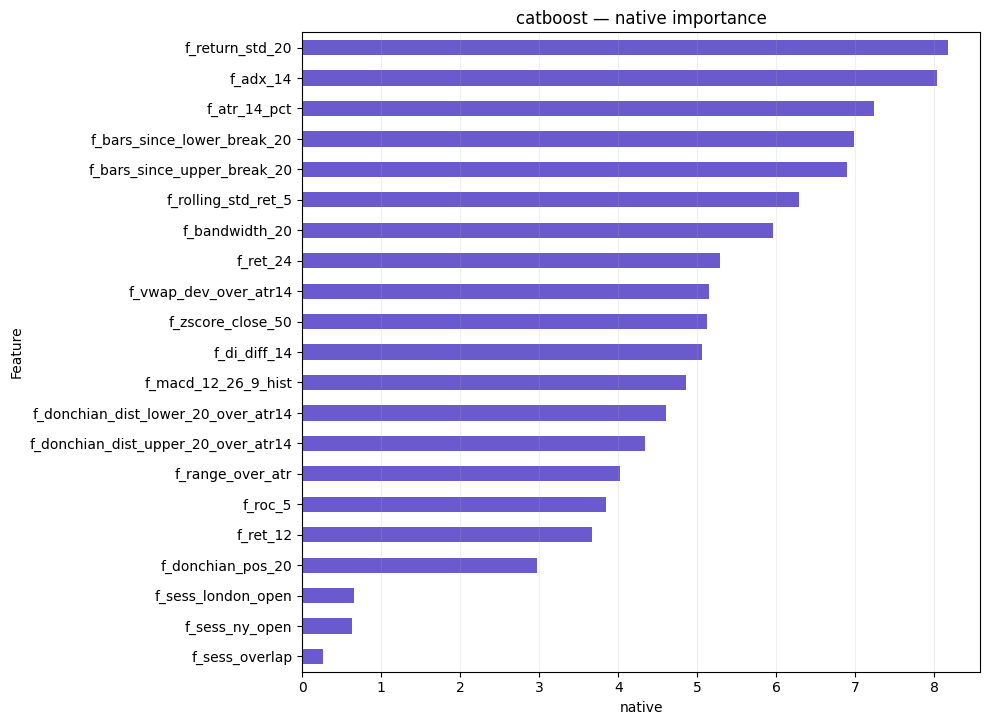

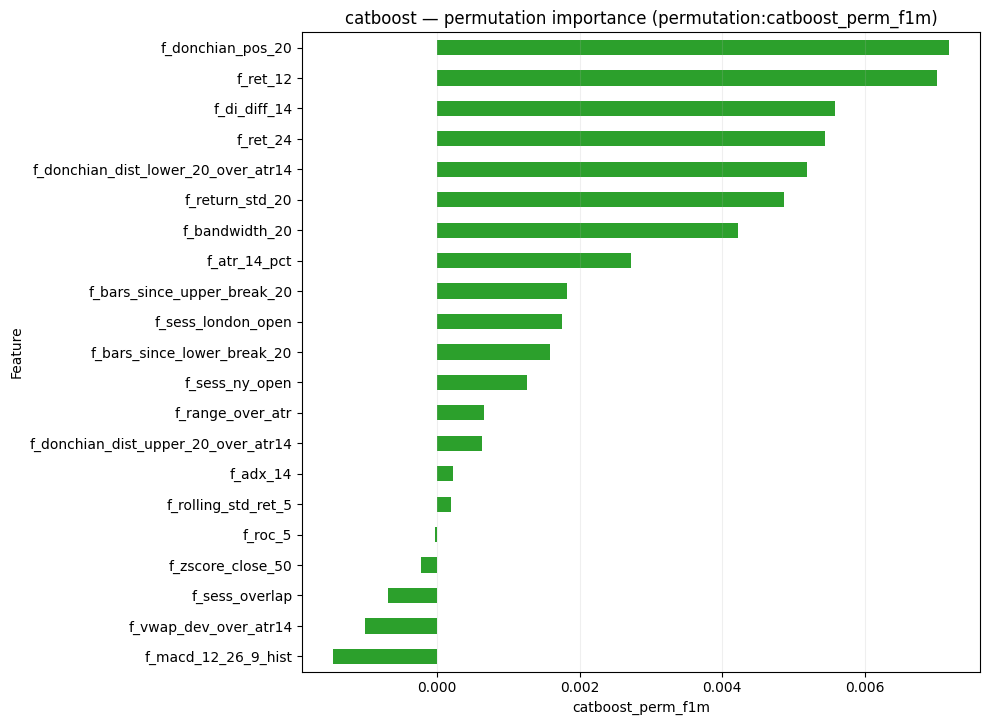

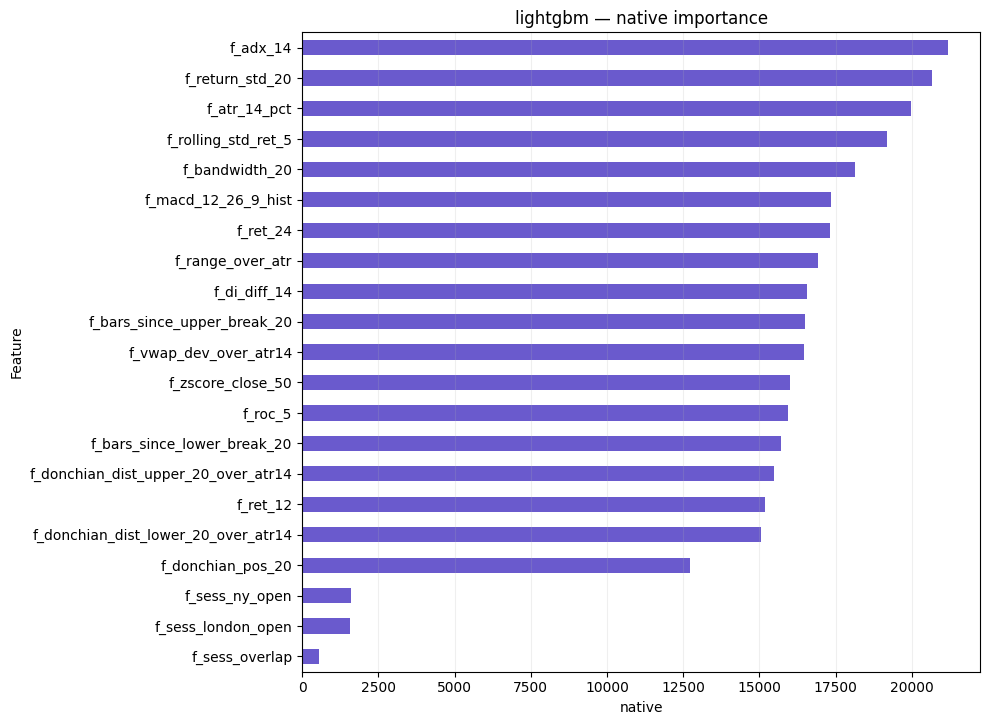

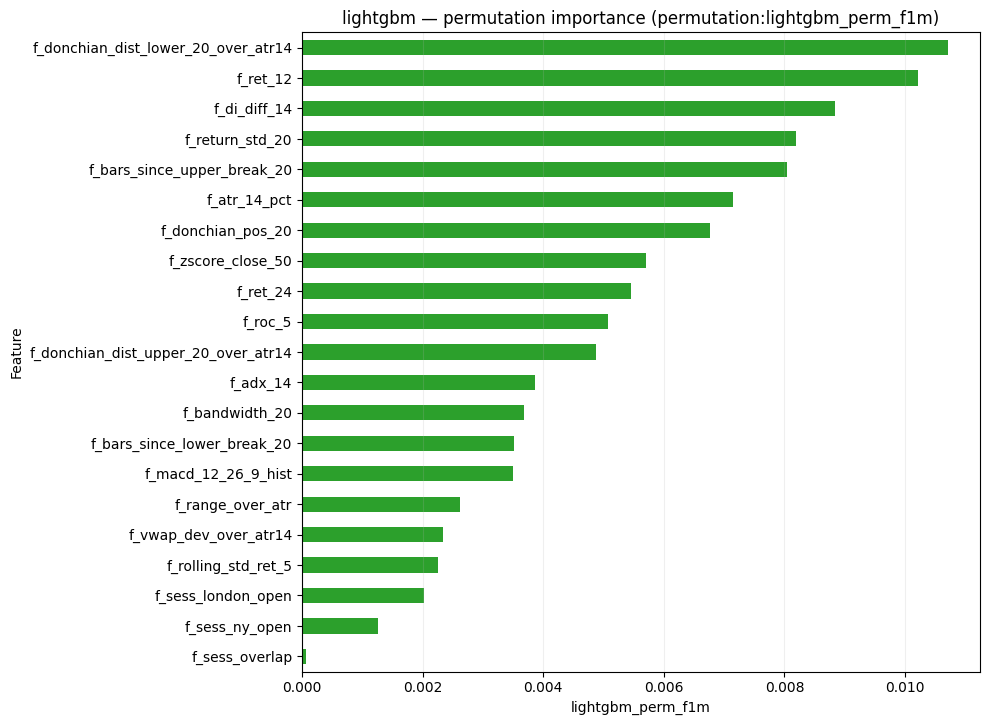

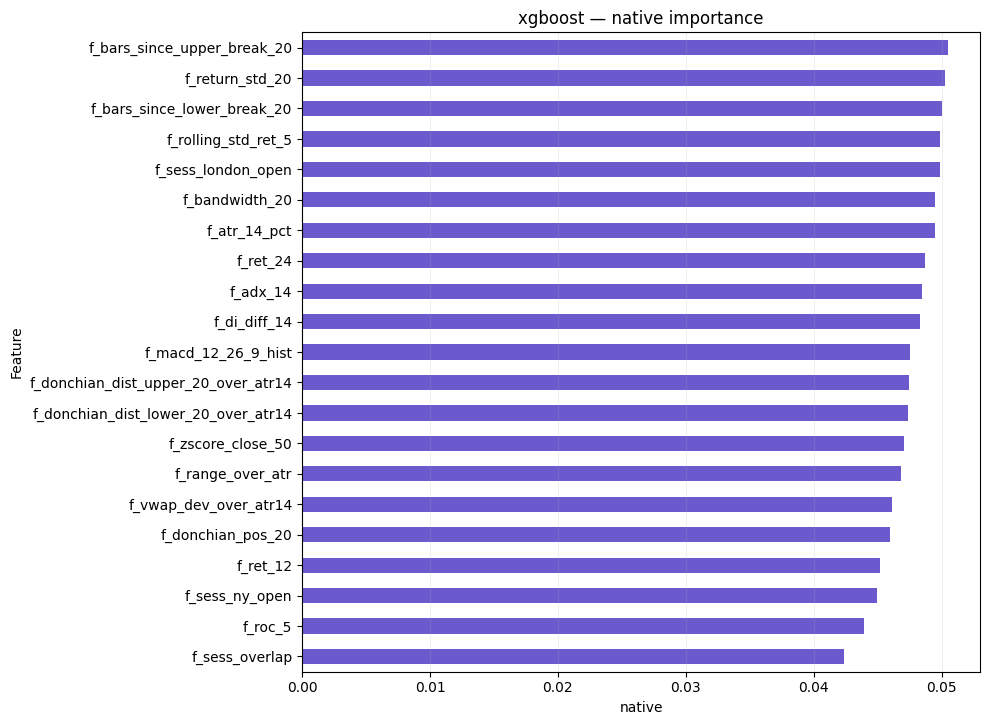

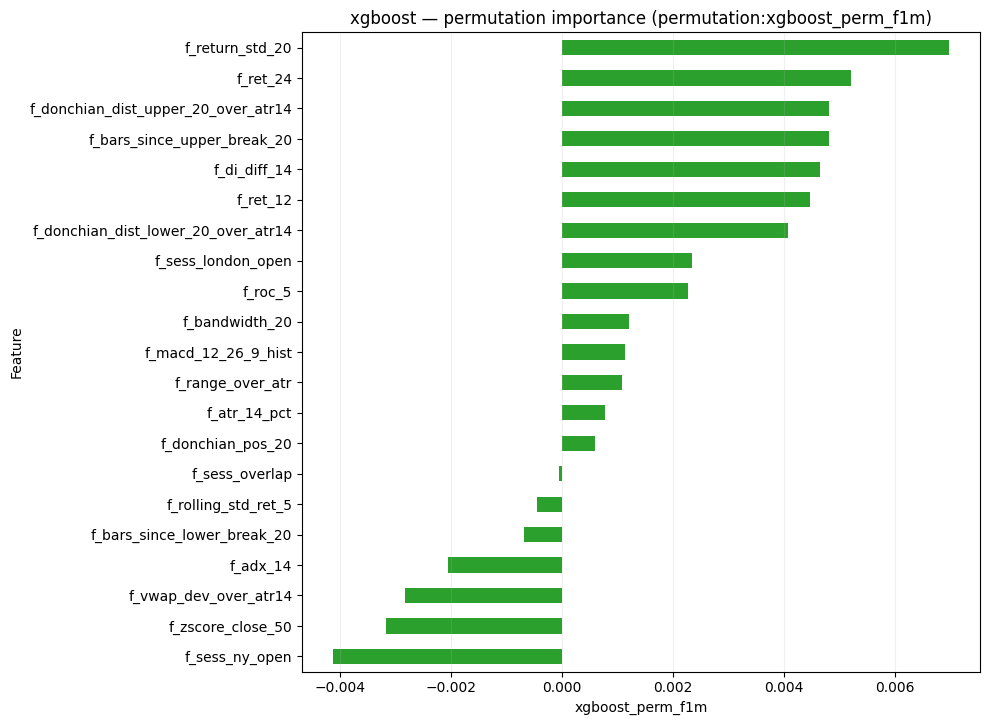

По-модельные PNG сохранены в: C:\Users\Shchurov\Хранилище\Документы\05_Программирование\02_projects\personal\trading_predictor\06_reports\exp_0014_20250924_012531\feature_importance


In [4]:
# По-модельные графики важности (native и permutation)
from pathlib import Path
import re
import pandas as pd
import matplotlib.pyplot as plt

summary_csv = Path(res["summary_importances"])  # noqa: F821
fi_dir = summary_csv.parent
summary_df = pd.read_csv(summary_csv, index_col=0)

# Найдём пары колонок по каждой модели
native_cols = [c for c in summary_df.columns if c.startswith("native:")]
perm_cols = [c for c in summary_df.columns if c.startswith("permutation:")]

# Извлечём имена моделей
def extract_model_from_native(col: str) -> str:
    # native:{model}_native
    m = re.match(r"^native:(.+?)_native$", col)
    return m.group(1) if m else col

def extract_model_from_perm(col: str) -> str:
    # permutation:{model}_perm_*
    m = re.match(r"^permutation:(.+?)_perm_", col)
    return m.group(1) if m else col

models_native = {extract_model_from_native(c): c for c in native_cols}
# Могут быть разные метрики perm_* — заберём первую на модель (или все)
models_perm = {}
for c in perm_cols:
    m = extract_model_from_perm(c)
    models_perm.setdefault(m, []).append(c)

# Параметры вывода
TOP_N = None  # None = все признаки

for model in sorted(set(list(models_native.keys()) + list(models_perm.keys()))):
    # Соберём серию native
    native_col = models_native.get(model)
    perm_col_list = models_perm.get(model, [])

    # Build native plot if present
    if native_col is not None and native_col in summary_df.columns:
        ser = summary_df[native_col].copy()
        ser = ser[ser.abs() > 0]
        if len(ser) > 0:
            top = ser.sort_values(ascending=True) if TOP_N is None else ser.sort_values(ascending=False).head(TOP_N).sort_values(ascending=True)
            plt.figure(figsize=(10, max(4, len(top) * 0.35)))
            top.plot(kind="barh", color="#6A5ACD")
            plt.xlabel("native")
            plt.ylabel("Feature")
            plt.title(f"{model} — native importance")
            plt.grid(axis="x", alpha=0.2)
            plt.tight_layout()
            out_png = fi_dir / f"bar_native_{model}.png"
            plt.savefig(out_png, dpi=200, bbox_inches="tight")
            plt.show()

    # Build permutation plots for each available metric column
    for perm_col in perm_col_list:
        if perm_col in summary_df.columns:
            serp = summary_df[perm_col].copy()
            serp = serp[serp.abs() > 0]
            if len(serp) == 0:
                continue
            top = serp.sort_values(ascending=True) if TOP_N is None else serp.sort_values(ascending=False).head(TOP_N).sort_values(ascending=True)
            plt.figure(figsize=(10, max(4, len(top) * 0.35)))
            top.plot(kind="barh", color="#2CA02C")
            plt.xlabel(perm_col.split(":",1)[-1])
            plt.ylabel("Feature")
            plt.title(f"{model} — permutation importance ({perm_col})")
            plt.grid(axis="x", alpha=0.2)
            plt.tight_layout()
            out_png = fi_dir / f"bar_perm_{model}_{perm_col.split(':',1)[-1]}.png"
            plt.savefig(out_png, dpi=200, bbox_inches="tight")
            plt.show()

print(f"По-модельные PNG сохранены в: {fi_dir}")



### По-модельные списки признаков (табличный вывод)

Печатаем топ признаков для каждой модели отдельно по колонкам `native:{model}_native` и `permutation:{model}_perm_*`. Можно ограничить `TOP_PRINT`.



In [5]:
# По-модельные списки (native/perm)
from pathlib import Path
import re
import pandas as pd

summary_csv = Path(res["summary_importances"])  # noqa: F821
summary_df = pd.read_csv(summary_csv, index_col=0)

native_cols = [c for c in summary_df.columns if c.startswith("native:")]
perm_cols = [c for c in summary_df.columns if c.startswith("permutation:")]

# Словари: модель -> колонка/колонки
models_native = {}
for c in native_cols:
    m = re.match(r"^native:(.+?)_native$", c)
    model = m.group(1) if m else c
    models_native[model] = c

models_perm = {}
for c in perm_cols:
    m = re.match(r"^permutation:(.+?)_perm_", c)
    model = m.group(1) if m else c
    models_perm.setdefault(model, []).append(c)

TOP_PRINT = None  # None = все признаки

for model in sorted(set(list(models_native.keys()) + list(models_perm.keys()))):
    print("\n" + "=" * 80)
    print(f"Модель: {model}")

    nat = models_native.get(model)
    if nat and nat in summary_df.columns:
        print("-" * 80)
        print(f"Native: {nat}")
        ser = summary_df[nat].sort_values(ascending=False)
        ser = ser[ser.abs() > 0]
        if TOP_PRINT is not None:
            ser = ser.head(TOP_PRINT)
        out = ser.reset_index()
        out.columns = ["feature", nat]
        with pd.option_context("display.max_rows", None, "display.max_colwidth", 80, "display.width", 120):
            print(out.to_string(index=False))

    perms = models_perm.get(model, [])
    for col in perms:
        if col in summary_df.columns:
            print("-" * 80)
            print(f"Permutation: {col}")
            ser = summary_df[col].sort_values(ascending=False)
            ser = ser[ser.abs() > 0]
            if TOP_PRINT is not None:
                ser = ser.head(TOP_PRINT)
            out = ser.reset_index()
            out.columns = ["feature", col]
            with pd.option_context("display.max_rows", None, "display.max_colwidth", 80, "display.width", 120):
                print(out.to_string(index=False))




Модель: catboost
--------------------------------------------------------------------------------
Native: native:catboost_native
                            feature  native:catboost_native
                    f_return_std_20                8.167277
                           f_adx_14                8.032676
                       f_atr_14_pct                7.239077
        f_bars_since_lower_break_20                6.984250
        f_bars_since_upper_break_20                6.889427
                f_rolling_std_ret_5                6.283714
                     f_bandwidth_20                5.954732
                           f_ret_24                5.281706
              f_vwap_dev_over_atr14                5.145435
                  f_zscore_close_50                5.116363
                       f_di_diff_14                5.060742
                f_macd_12_26_9_hist                4.860499
f_donchian_dist_lower_20_over_atr14                4.600869
f_donchian_dist_upper_20_over_